In [1]:
import os, sys, time, re, random, math, json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math

%matplotlib inline
print(sys.version)

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]


## Load the Sample Dataset

Along with this jupyter notebook you should have received one other file called `berlin_ards.json` (Please unzip if you receive a zip file). It is a json file containing the data that we will be working with for this project. Load it with the cell below

In [2]:
with open('berlin_ards.json') as json_file:
    berlin_ards = json.load(json_file)

## Introduction to the Sample Dataset

This sample dataset is a subset taken from a freely accessible critical care database. `berlin_ards` above is a dictionary of patient encounters. An encounter is one hospitalization. One patient can have multiple admissions to the hospital. Each admission would have a unique encounter_ID. In this dataset the times have been modified but the time intervals are real. Run the cells below to get acquainted.

In [3]:
keys = list(berlin_ards.keys())
num_encs = len(keys)
print("There are {} patient encounters in this dataset".format(num_encs))

There are 8709 patient encounters in this dataset


In [4]:
print("{} is an example of an encounter ID".format(keys[0]))

200021 is an example of an encounter ID


plug the encounter ID into the dictionary to see information about this patient's encounter

here is some basic information about this hospitalization and all the keys to the other types of data for this encounter

In [5]:
enc = berlin_ards[keys[0]]
print('')
print(enc['Info'])
enc.keys()


{'age': 60.0, 'gender': 'M', 'weight': 82.6, 'subject_id': '61691', 'is_in_hospital_death': False, 'is_Berlin_ARDS': False, 'first_measurement_time': '2114-12-26T20:40:00', 'is_Berlin_time': '2114-12-26T21:23:00', 'last_measurement_time': '2114-12-27T22:00:00'}


dict_keys(['Info', 'feature_matrix_row_names', 'feature_sampling_interval_minutes', 'feature_matrix'])

Most of this you will have to figure out for yourself, but lets go over some special data components

First, we have given you a feature matrix of timeseries features where each row is a different vital sign or lab measurement and each column is a different timestep starting with column 0 = time zero.  

As an example, here are the first 24 hours of oxygen saturation (SpO2) measurements. The first SpO2 measurement was made 60 minutes into the stay, which is why the first 2 columns are not a number

In [6]:
print(enc['feature_matrix_row_names'])
period = enc['feature_sampling_interval_minutes']
print('number of features', len(enc['feature_matrix_row_names']))
print('minutes between timesteps', period)
feature_index = 5
print(enc['feature_matrix_row_names'][feature_index])
feature_matrix = np.array(enc['feature_matrix'])
print(feature_matrix[feature_index,:int(24*60/period)])
print(feature_matrix.shape)

['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
number of features 9
minutes between timesteps 30
SpO2
[nan nan 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 98. 98. 96. 96. 94.
 94. 97. 97. 96. 96. 96. 96. 94. 94. 94. 94. 94.]
(9, 51)


### Sanity Check

The length of stay should be within one period of the amount of time represented by the feature matrix

In [7]:
start_time = datetime.strptime(enc['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
stop_time = datetime.strptime(enc['Info']['last_measurement_time'], '%Y-%m-%dT%H:%M:%S')

lenofstay_mins = (stop_time - start_time).total_seconds()/60
print((lenofstay_mins/60), 'hours', feature_matrix.shape[1]*period/60, 'hours')

25.333333333333332 hours 25.5 hours


# Exploring the Data

For the 3 features: 

    a. Systolic Blood Pressure (SysABP)

    b. Temperature (Temp) 

    c. White Blood Cell Count (WBC)
    
## TODOs:

1. Generate figures to describe the distribution of these features: ie their variability and central tendency. Make the figures as easy to read and self-explainatory as possible as if you were going to publish them. 

2. Look up each these 3 features. Have you plotted a clinically plausible, ie physiologically distributed, spread of measurements that you would expect for each feature ? 

    - Yes, the normal Systolic Blood Pressure is around 110-120(mmHg).
    - Yes, The normal Temperature is around 37 Celsius
    - Yes, the normal WBC is 4.5k - 11k WBC's per microliter
    
    
3. What are the units of measurment each feature likely uses ? 

    A) Systolic Blood Pressure: units of millimeters of mercury (mmHg)
    
    B) Temperature: Celsius
    
    C) White Blood Cell Count: K/uL
    

# EDA/Sample Distributions

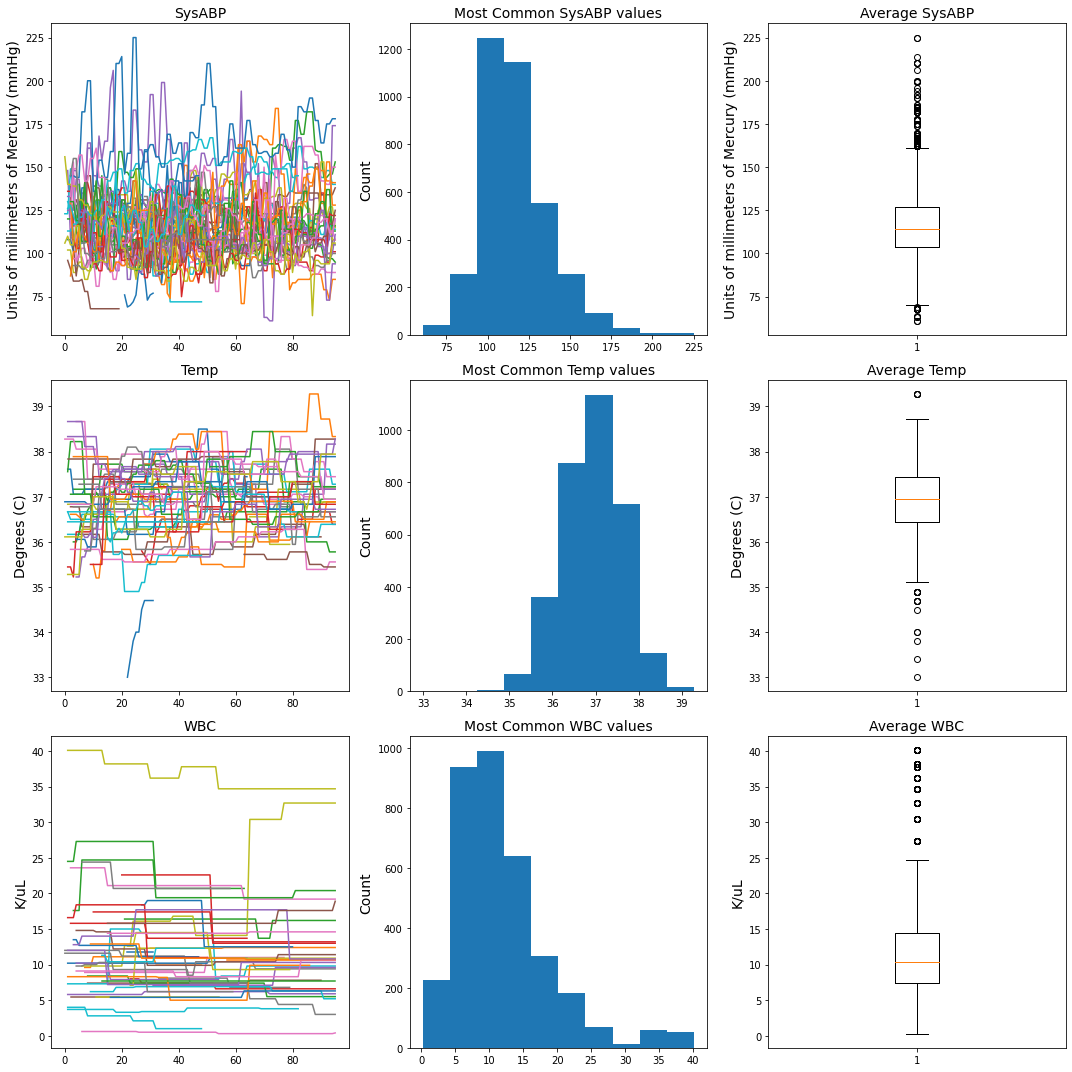

In [8]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
l1 = []
l2 = []
l3 = []
ind = [0, 3, 7]
features = ['SysABP', 'Temp', 'WBC']
hist_list = [l1, l2, l3]
samples = random.sample(list(range(len(keys))), 50)
for i in range(3):

    for x in samples:
        period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
        axs[i][0].plot(berlin_ards[keys[x]]['feature_matrix'][ind[i]][:round(24*2*60/period)])
        hist_list[i] = hist_list[i] + berlin_ards[keys[x]]['feature_matrix'][ind[i]][:round(24*2*60/period)] 
        axs[i][0].set_title(features[i], fontsize = 14)
        
    axs[i][1].hist(hist_list[i])
    axs[i][1].set_title('Most Common ' + features[i] + ' values', fontsize = 14)
    axs[i][1].set_ylabel('Count', fontsize = 14)
    w = np.array(hist_list[i])
    w = w[~np.isnan(w)]
    axs[i][2].boxplot(w)
    axs[i][2].set_title('Average ' + features[i], fontsize = 14)
    

for i in [0, 2]:
    axs[0][i].set_ylabel('Units of millimeters of Mercury (mmHg)', fontsize = 14)
    axs[1][i].set_ylabel('Degrees (C)', fontsize = 14)
    axs[2][i].set_ylabel('K/uL', fontsize = 14)
plt.tight_layout()

# Machine Learning

ARDS or [Acute respiratory distress syndrome](https://www.uptodate.com/contents/acute-respiratory-distress-syndrome-clinical-features-diagnosis-and-complications-in-adults) is a difficult disease both to define and also to predict. The definition of ARDS we will be using is the Berlin Criteria (Lung imaging shows Bilateral Infiltrates and PaO2/FiO2 is < 300). We are going to have you design and train an algorithm to predict the onset of ARDS before it occurs as best you can using the limited data in this sample dataset. The target labels are provided for you for each patient encounter, see below:

In [9]:
encounter_index = 1
print('Did this patient develope ARDS according to the Berlin Criteria?',berlin_ards[keys[encounter_index]]['Info']['is_Berlin_ARDS'])
print('Time Berlin Criteria was evaluated',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_time'])

Did this patient develope ARDS according to the Berlin Criteria? False
Time Berlin Criteria was evaluated 2127-03-03T17:27:00


### Guidelines

a. You can choose which machine learning algorithm and python packages to use 

b. You can choose which features to use. 

c. Only use features as inputs to the algorithm that are available at or before the time you plan to make the prediction. If ARDS occurs at 48 hours into the hospitalization and your machine learning algorithm makes a prediction at 24 hours into the hospitalization, make sure you are not using information from the dataset that becomes available only after 24 hours. 


## TODOs:

1. Set aside a portion of the encounters to use as the hold out test set.

2. Train and validate the algorithm on the remaining dataset.

2. Plot the area under the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) aka AUC on the hold out test set. 

3. Generate a figure to help us understand how the algorithm makes it's decisions. ie address model interpretability. 

In [10]:
#### Which cases were True and False by Index #####
count = 0
true_cases = []
false_cases = []
berlin_true = {}
while count < len(keys):
    if berlin_ards[keys[count]]['Info']['is_Berlin_ARDS'] == True:
        true_cases.append(count)
        count = count + 1      
    else:
        false_cases.append(count)
        count = count + 1

#### WRITE CODE HERE #####

In [11]:
len(true_cases)

439

In [12]:
len(false_cases)

8270

# Gender/Age 

Features: 'SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets'

In [13]:
#### WRITE CODE HERE #####
'"Average Ages for Both Classes and gender count"'
count2_male_t = 0
count2_female_t = 0
count2_male_f = 0
count2_female_f = 0
age_male_true = 0
age_male_false = 0
age_female_true = 0
age_female_false = 0

for x in true_cases:
    if berlin_ards[keys[x]]['Info']['gender'] == 'M':
        age_male_true = age_male_true + berlin_ards[keys[x]]['Info']['age'] 
        count2_male_t += 1
    else:
        age_female_true = age_female_true + berlin_ards[keys[x]]['Info']['age'] 
        count2_female_t += 1

for x in false_cases:
    if berlin_ards[keys[x]]['Info']['gender'] == 'M':
        age_male_false = age_male_false + berlin_ards[keys[x]]['Info']['age'] 
        count2_male_f += 1
    else:
        age_female_false = age_female_false + berlin_ards[keys[x]]['Info']['age'] 
        count2_female_f += 1

In [14]:
avg_male_true = age_male_true/count2_male_t
avg_female_true = age_female_true/count2_female_t
avg_male_false = age_male_false/count2_male_f
avg_female_false = age_female_false/count2_female_f

# Plotting Gender/Age differences by Class

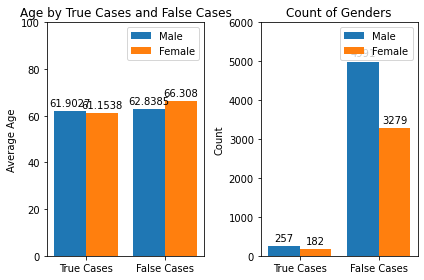

In [15]:
plt.subplot(1, 2, 1)
gender = ['True Cases', 'False Cases']

x = np.arange(len(gender))
y1 = [avg_male_true, avg_male_false]
y2 = [avg_female_true, avg_female_false]
width = 0.40
  
# plot data in grouped manner of bar type
y = plt.bar(x-0.2, y1, width, label = 'Male')
z = plt.bar(x+0.2, y2, width, label = 'Female')
plt.ylabel('Average Age')
plt.title('Age by True Cases and False Cases')
plt.xticks(x, gender)
plt.bar_label(y, padding=3)
plt.bar_label(z, padding=3)
plt.ylim((0,100))

plt.legend(['Male', 'Female'])
plt.tight_layout()

plt.subplot(1, 2, 2)
gender = ['True Cases', 'False Cases']

x = np.arange(len(gender))
y1 = [count2_male_t, count2_male_f]
y2 = [count2_female_t, count2_female_f]
width = 0.40
  
# plot data in grouped manner of bar type
y = plt.bar(x-0.2, y1, width, label = 'Male')
z = plt.bar(x+0.2, y2, width, label = 'Female')
plt.ylabel('Count')
plt.title('Count of Genders')
plt.xticks(x, gender)
plt.bar_label(y, padding=3)
plt.bar_label(z, padding=3)
plt.ylim((0,6000))

plt.legend(['Male', 'Female'])
plt.tight_layout()

More Males In General, the age difference is not significant

# Graphing All Features 

(0.0, 500.0)

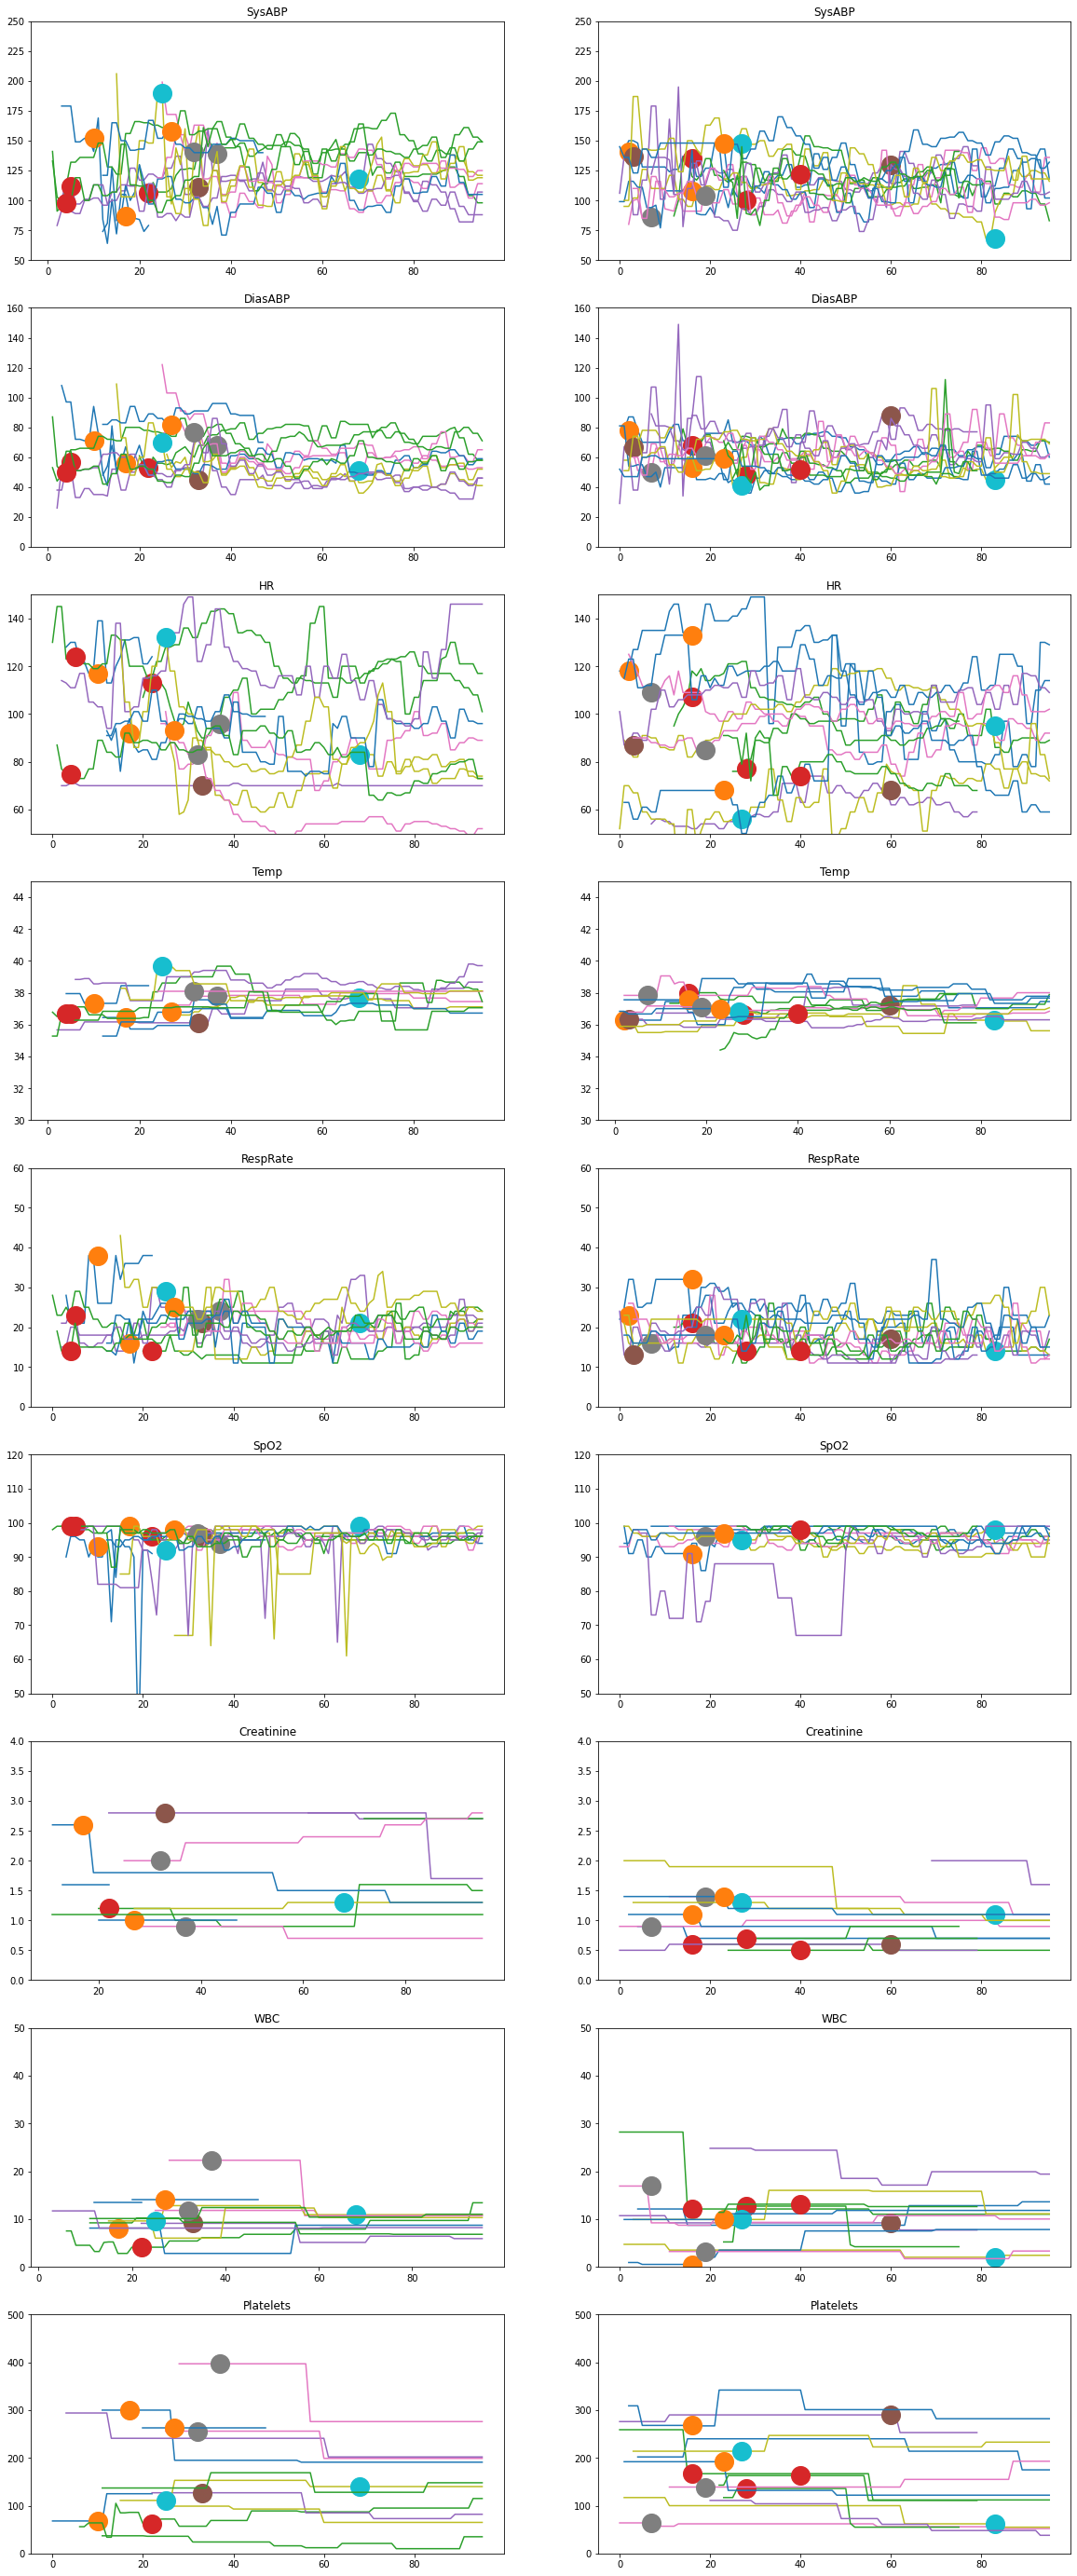

In [16]:
fig, axs = plt.subplots(9,2, figsize = (20,50))
#True samples and false samples are lists which contain the indices for true and cases in the keys dictionary.
true_samples = random.sample(true_cases, 12)
false_samples = random.sample(false_cases, 12)

#Every Feature/Vital
for i in range(9):

    for x in true_samples:
        period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
        start_time = datetime.strptime(berlin_ards[keys[x]]['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
        stop_time = datetime.strptime(berlin_ards[keys[x]]['Info']['is_Berlin_time'], '%Y-%m-%dT%H:%M:%S')
        time_mins = (stop_time - start_time).total_seconds()/60
        time_measure = time_mins/60
        time_period = round(time_measure * (60/period))
        
        
        axs[i][0].plot(berlin_ards[keys[x]]['feature_matrix'][i][:round(24*2*60/period)])
        axs[i][0].plot(time_period, berlin_ards[keys[x]]['feature_matrix'][i][(time_period)-1],'o', markersize=20)
        axs[i][0].set_title(enc['feature_matrix_row_names'][i])

    for x in false_samples:
        period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
        start_time = datetime.strptime(berlin_ards[keys[x]]['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
        stop_time = datetime.strptime(berlin_ards[keys[x]]['Info']['is_Berlin_time'], '%Y-%m-%dT%H:%M:%S')
        time_mins = (stop_time - start_time).total_seconds()/60
        time_measure = time_mins/60
        time_period = round(time_measure * (60/period))
        
        axs[i][1].plot(berlin_ards[keys[x]]['feature_matrix'][i][:round(24*2*60/period)])
        axs[i][1].plot(time_period, berlin_ards[keys[x]]['feature_matrix'][i][(time_period)-1],'o', markersize=20)
        axs[i][1].set_title(enc['feature_matrix_row_names'][i])


axs[0][0].set_ylim(50,250)
axs[1][0].set_ylim(0,160)
axs[2][0].set_ylim(50,150)
axs[3][0].set_ylim(30,45)
axs[4][0].set_ylim(0,60)
axs[5][0].set_ylim(50,120)
axs[6][0].set_ylim(0,4)
axs[7][0].set_ylim(0,50)
axs[8][0].set_ylim(0,500)
axs[0][1].set_ylim(50,250)
axs[1][1].set_ylim(0,160)
axs[2][1].set_ylim(50,150)
axs[3][1].set_ylim(30,45)
axs[4][1].set_ylim(0,60)
axs[5][1].set_ylim(50,120)
axs[6][1].set_ylim(0,4)
axs[7][1].set_ylim(0,50)
axs[8][1].set_ylim(0,500)

# These are graphs of 10 random patients and their vitals measured over time. The left side are the true cases and the left are the false ones. The dots signify the time which they were tested for ARDS.

# Data Preprocessing and storing into DataFrame

In [17]:
features = enc['feature_matrix_row_names']
cases_all_df = pd.DataFrame(index = range(len(keys)), columns = range(48))

#Every patient's data plus/minus five vital measurements is stored in the dataframe.
#There is a lot of missing data however and a lot of cases where the vitals 
#measured for ARD wasn't within the time frame or was nan.
#This part was extremely difficult, due to missing values and ARD time not syncing with vital measurements.

for x in range(len(keys)):
    period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
    start_time = datetime.strptime(berlin_ards[keys[x]]['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
    stop_time = datetime.strptime(berlin_ards[keys[x]]['Info']['is_Berlin_time'], '%Y-%m-%dT%H:%M:%S')
    time_mins = (stop_time - start_time).total_seconds()/60
    time_measure = abs(time_mins)/60
    time_period = round(time_measure * (60/period))
    if time_period <= 0.5:
        time_period = round(time_period + 0.51) - 1
    else:
        time_period = time_period - 1
    list2 = []
    list3 = []
    print(period, time_measure, time_period)

    for i in range(9):
        if time_period > len(berlin_ards[keys[x]]['feature_matrix'][i][:]):
            break


        if math.isnan(berlin_ards[keys[x]]['feature_matrix'][i][time_period]) == True:
            list3 = (np.array(berlin_ards[keys[x]]['feature_matrix'][i][:]))
            nan_array = np.isnan(list3)
            list3_nans = list3[nan_array]
            if len(list3_nans) >= len(list3)/2:
                print(x)
                break
                
            else:
                if time_period >= len(list3)/2:
                    nan_array = np.isnan(list3)
                    not_nan_array = ~ nan_array
                    list3 = list3[not_nan_array]
                    list2.append(list3[-5: ])
                else:
                    nan_array = np.isnan(list3)
                    not_nan_array = ~ nan_array
                    list3 = list3[not_nan_array]
                    list2.append([list3[0]] * 5)  

        elif math.isnan(berlin_ards[keys[x]]['feature_matrix'][i][time_period-1]) == True:
            list2.append([berlin_ards[keys[x]]['feature_matrix'][i][time_period]] * 5)

        else:
            for z in range(0, time_period):
                if math.isnan(berlin_ards[keys[x]]['feature_matrix'][i][z]) == True:
                    continue
                else:
                    if time_period < 5:
                        length = len(berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                        list2.append([berlin_ards[keys[x]]['feature_matrix'][i][z]] * (5-length)
                                     + berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                        break
                    else:
                        if (time_period + 1) - z >= 5:
                            list2.append(berlin_ards[keys[x]]['feature_matrix'][i][(time_period + 1) - 5: time_period + 1])
                            break
                        else:
                            length = len(berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                            list2.append([berlin_ards[keys[x]]['feature_matrix'][i][z]] * (5 - length) 
                                         + berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                            break
                            
    list2_arr = np.array(list2) 
    if list2_arr.size == 45:
        cases_all_df.at[x, :44] = np.reshape(list2_arr, (1,45))
        cases_all_df.at[x, 45] = time_period
        cases_all_df.at[x, 46] = x
        if x in false_cases:
            cases_all_df.at[x, 47] = 'False'
        else:
            cases_all_df.at[x, 47] = 'True'
    else:
        continue

30 0.7166666666666667 0
30 1.7 2
1
30 1.0666666666666667 1
30 0.25 0
30 8.25 15
30 0.9166666666666666 1
30 7.916666666666667 15
30 28.433333333333334 56
30 9.15 17
30 0.65 0
30 2.0166666666666666 3
10
30 17.166666666666668 33
11
30 32.25 63
30 11.583333333333334 22
30 5.933333333333334 11
30 9.65 18
30 0.4166666666666667 0
30 36.31666666666667 72
30 49.766666666666666 99
30 10.266666666666667 20
30 14.716666666666667 28
30 28.583333333333332 56
30 5.65 10
30 1.9833333333333334 3
30 27.083333333333332 53
30 3.1666666666666665 5
30 21.566666666666666 42
30 14.233333333333333 27
30 5.583333333333333 10
30 0.8833333333333333 1
29
30 8.15 15
30 8.683333333333334 16
31
30 18.5 36
30 45.03333333333333 89
30 1.8 3
30 11.016666666666667 21
30 5.8 11
36
30 2.65 4
30 48.11666666666667 95
30 6.266666666666667 12
30 18.183333333333334 35
30 31.4 62
30 6.683333333333334 12
30 49.1 97
30 23.25 45
44
30 1.5 2
30 11.516666666666667 22
30 22.366666666666667 44
30 27.183333333333334 53
30 48.85 97
30 13.

30 13.1 25
30 15.083333333333334 29
30 9.566666666666666 18
30 5.933333333333334 11
30 24.733333333333334 48
434
30 1.65 2
30 4.4 8
30 0.6666666666666666 0
30 12.016666666666667 23
30 5.633333333333334 10
30 14.316666666666666 28
30 16.05 31
30 6.2 11
30 18.4 36
30 29.983333333333334 59
30 101.66666666666667 202
30 13.216666666666667 25
30 30.816666666666666 61
30 40.05 79
30 44.3 88
30 7.916666666666667 15
30 12.55 24
30 19.066666666666666 37
30 25.3 50
453
30 3.716666666666667 6
30 23.9 47
455
30 20.083333333333332 39
30 1.9833333333333334 3
30 40.8 81
458
30 38.88333333333333 77
459
30 2.183333333333333 3
30 38.666666666666664 76
30 63.03333333333333 125
30 1.3333333333333333 2
30 40.85 81
30 16.7 32
465
30 8.416666666666666 16
30 8.583333333333334 16
30 6.983333333333333 13
30 18.933333333333334 37
30 20.416666666666668 40
30 52.36666666666667 104
471
30 16.35 32
30 6.516666666666667 12
30 16.45 32
474
30 0.2 0
30 21.166666666666668 41
30 11.75 23
30 1.7333333333333334 2
30 3.7 6
4

30 21.566666666666666 42
917
30 3.966666666666667 7
30 37.1 73
30 9.466666666666667 18
30 6.566666666666666 12
30 9.933333333333334 19
922
30 19.4 38
30 36.86666666666667 73
30 3.3833333333333333 6
30 38.43333333333333 76
30 34.63333333333333 68
927
30 8.033333333333333 15
30 4.35 8
30 22.966666666666665 45
30 7.766666666666667 15
30 13.666666666666666 26
30 25.533333333333335 50
30 2.783333333333333 5
30 38.15 75
30 14.5 28
30 5.233333333333333 9
937
30 23.883333333333333 47
30 15.766666666666667 31
30 65.76666666666667 131
30 3.7333333333333334 6
30 2.816666666666667 5
30 22.5 44
30 28.633333333333333 56
944
30 81.9 163
945
30 16.9 33
30 25.65 50
30 5.8 11
30 4.633333333333334 8
30 18.233333333333334 35
30 30.033333333333335 59
30 4.283333333333333 8
30 2.2666666666666666 4
30 4.45 8
954
30 48.95 97
30 15.466666666666667 30
30 40.31666666666667 80
957
30 1.5166666666666666 2
30 9.533333333333333 18
959
30 14.283333333333333 28
30 5.833333333333333 11
30 15.0 29
30 14.916666666666666 

30 20.216666666666665 39
30 45.88333333333333 91
30 2.15 3
30 6.733333333333333 12
30 48.083333333333336 95
30 10.966666666666667 21
30 25.383333333333333 50
30 1.5666666666666667 2
1443
30 6.166666666666667 11
30 11.05 21
30 3.783333333333333 7
30 20.233333333333334 39
30 18.233333333333334 35
30 12.033333333333333 23
30 21.366666666666667 42
30 5.583333333333333 10
30 6.533333333333333 12
30 2.5833333333333335 4
30 31.2 61
30 26.116666666666667 51
30 3.7 6
1456
30 7.816666666666666 15
30 53.166666666666664 105
30 19.25 37
30 4.916666666666667 9
30 36.3 72
1461
30 18.116666666666667 35
30 39.5 78
1463
30 16.783333333333335 33
30 16.783333333333335 33
30 18.733333333333334 36
30 6.816666666666666 13
30 49.68333333333333 98
1468
30 42.1 83
30 18.0 35
1470
30 18.033333333333335 35
30 0.6833333333333333 0
30 55.483333333333334 110
30 19.816666666666666 39
30 0.6333333333333333 0
30 22.433333333333334 44
30 7.783333333333333 15
30 1.0 1
30 19.066666666666666 37
30 1.1666666666666667 1
30 1

30 17.383333333333333 34
30 49.2 97
30 0.7333333333333333 0
30 11.266666666666667 22
30 22.983333333333334 45
30 12.85 25
30 15.716666666666667 30
30 6.766666666666667 13
30 9.333333333333334 18
30 13.05 25
30 15.666666666666666 30
30 37.2 73
1927
30 7.133333333333334 13
30 28.883333333333333 57
30 6.316666666666666 12
30 51.016666666666666 101
30 16.883333333333333 33
30 1.2666666666666666 2
30 37.06666666666667 73
30 43.983333333333334 87
30 15.7 30
30 16.783333333333335 33
1937
30 41.88333333333333 83
30 221.05 441
30 8.683333333333334 16
30 6.066666666666666 11
30 42.266666666666666 84
30 7.65 14
1943
30 39.416666666666664 78
30 4.733333333333333 8
30 2.783333333333333 5
30 1.95 3
30 47.93333333333333 95
30 2.316666666666667 4
30 14.166666666666666 27
30 12.7 24
30 13.483333333333333 26
30 7.783333333333333 15
30 46.75 93
30 48.03333333333333 95
30 16.916666666666668 33
30 2.033333333333333 3
30 43.766666666666666 87
30 40.45 80
30 3.65 6
30 33.9 67
30 23.866666666666667 47
30 50.3

30 31.383333333333333 62
30 39.483333333333334 78
30 13.033333333333333 25
30 1.1 1
30 3.9 7
30 7.416666666666667 14
30 4.466666666666667 8
30 4.4 8
30 15.883333333333333 31
30 9.283333333333333 18
30 1.9 3
30 66.38333333333334 132
30 6.55 12
30 57.61666666666667 114
30 27.85 55
30 15.916666666666666 31
30 8.083333333333334 15
2402
30 1.7 2
30 12.566666666666666 24
30 23.45 46
30 162.78333333333333 325
30 0.06666666666666667 0
30 4.066666666666666 7
30 1.1333333333333333 1
30 22.916666666666668 45
2410
30 31.233333333333334 61
30 81.61666666666666 162
30 2.5833333333333335 4
30 7.25 13
30 19.533333333333335 38
30 29.8 59
30 22.283333333333335 44
30 9.1 17
30 6.133333333333334 11
30 28.016666666666666 55
30 8.366666666666667 16
30 20.033333333333335 39
30 21.016666666666666 41
30 4.65 8
30 13.233333333333333 25
2425
30 13.733333333333333 26
30 1.8666666666666667 3
30 19.783333333333335 39
30 12.8 25
30 7.05 13
2430
30 31.416666666666668 62
30 11.333333333333334 22
30 2.4166666666666665 

30 3.15 5
30 16.883333333333333 33
30 22.0 43
2839
30 4.416666666666667 8
30 15.766666666666667 31
30 17.583333333333332 34
30 34.93333333333333 69
30 8.95 17
2844
30 23.116666666666667 45
30 22.2 43
30 5.333333333333333 10
30 9.6 18
30 17.083333333333332 33
30 25.833333333333332 51
30 7.0 13
30 44.63333333333333 88
30 38.016666666666666 75
30 88.7 176
30 16.0 31
30 3.1166666666666667 5
30 0.95 1
30 20.883333333333333 41
30 14.05 27
30 45.6 90
2860
30 48.083333333333336 95
30 20.65 40
30 17.683333333333334 34
30 9.216666666666667 17
30 29.916666666666668 59
30 4.783333333333333 9
30 30.466666666666665 60
30 14.45 28
30 46.55 92
30 9.983333333333333 19
30 7.583333333333333 14
30 1.3 2
30 4.5 8
30 42.18333333333333 83
30 40.31666666666667 80
30 19.933333333333334 39
30 32.81666666666667 65
30 1.3 2
30 41.35 82
30 17.166666666666668 33
30 3.75 7
30 2.066666666666667 3
30 27.866666666666667 55
30 6.4 12
30 17.283333333333335 34
30 1.0666666666666667 1
30 40.0 79
30 22.416666666666668 44
28

30 1.0833333333333333 1
30 21.366666666666667 42
30 34.21666666666667 67
30 2.8333333333333335 5
30 26.016666666666666 51
30 11.2 21
30 15.283333333333333 30
30 51.6 102
30 16.266666666666666 32
30 8.366666666666667 16
30 11.45 22
30 20.483333333333334 40
3443
30 26.833333333333332 53
30 8.183333333333334 15
30 16.316666666666666 32
30 3.6 6
30 38.85 77
3448
30 19.95 39
30 10.916666666666666 21
30 11.433333333333334 22
30 8.433333333333334 16
30 19.2 37
30 10.233333333333333 19
30 38.65 76
30 9.366666666666667 18
30 15.933333333333334 31
3457
30 13.666666666666666 26
3458
30 5.4 10
30 21.75 43
30 11.416666666666666 22
30 28.066666666666666 55
3462
30 4.883333333333334 9
30 7.066666666666666 13
30 21.233333333333334 41
30 4.433333333333334 8
30 7.433333333333334 14
30 5.6 10
30 15.016666666666667 29
30 18.1 35
3470
30 24.55 48
30 20.066666666666666 39
30 42.166666666666664 83
30 6.95 13
30 17.316666666666666 34
3475
30 22.166666666666668 43
30 27.483333333333334 54
3477
30 2.28333333333

30 3.216666666666667 5
30 39.233333333333334 77
30 6.366666666666666 12
30 54.333333333333336 108
30 23.116666666666667 45
30 5.616666666666666 10
30 39.583333333333336 78
30 45.483333333333334 90
30 11.166666666666666 21
30 2.8833333333333333 5
30 32.45 64
3899
30 2.316666666666667 4
30 31.033333333333335 61
30 3.6 6
30 13.516666666666667 26
30 3.6 6
3904
30 17.466666666666665 34
30 27.166666666666668 53
30 31.116666666666667 61
30 20.25 39
3908
30 5.15 9
30 4.85 9
30 7.016666666666667 13
30 38.81666666666667 77
30 21.233333333333334 41
30 5.833333333333333 11
30 16.05 31
30 20.966666666666665 41
30 54.21666666666667 107
30 27.833333333333332 55
30 5.233333333333333 9
3919
30 35.016666666666666 69
3920
30 36.9 73
30 3.933333333333333 7
30 1.4833333333333334 2
30 14.7 28
30 3.2333333333333334 5
30 15.183333333333334 29
30 16.3 32
30 3.9833333333333334 7
30 4.283333333333333 8
30 12.75 25
30 37.05 73
30 14.883333333333333 29
30 29.866666666666667 59
30 4.55 8
30 3.3333333333333335 6
30 

30 1.8833333333333333 3
30 3.1666666666666665 5
4471
30 44.06666666666667 87
30 40.916666666666664 81
30 0.8 1
30 12.883333333333333 25
30 14.166666666666666 27
30 50.8 101
30 19.75 39
30 6.266666666666667 12
30 8.833333333333334 17
30 13.166666666666666 25
30 9.966666666666667 19
30 6.816666666666666 13
30 37.766666666666666 75
30 1.05 1
30 114.61666666666666 228
30 38.016666666666666 75
30 2.566666666666667 4
30 2.05 3
30 29.116666666666667 57
30 18.816666666666666 37
4491
30 9.116666666666667 17
30 11.666666666666666 22
30 4.85 9
30 38.5 76
30 33.4 66
4496
30 4.983333333333333 9
4497
30 10.583333333333334 20
30 10.033333333333333 19
30 40.333333333333336 80
30 17.683333333333334 34
30 17.75 35
30 26.833333333333332 53
30 14.25 27
30 17.3 34
4505
30 10.666666666666666 20
30 11.283333333333333 22
30 68.71666666666667 136
30 32.43333333333333 64
30 3.8666666666666667 7
30 10.316666666666666 20
30 1.1 1
30 15.75 31
30 16.983333333333334 33
30 7.983333333333333 15
30 3.4833333333333334 6

30 15.983333333333333 31
30 7.783333333333333 15
30 11.783333333333333 23
30 41.483333333333334 82
30 62.88333333333333 125
30 24.183333333333334 47
30 5.083333333333333 9
5059
30 12.55 24
30 3.066666666666667 5
30 17.416666666666668 34
30 7.3 14
30 10.633333333333333 20
30 18.583333333333332 36
30 14.233333333333333 27
30 14.266666666666667 28
30 1.4333333333333333 2
30 35.61666666666667 70
30 26.233333333333334 51
30 6.733333333333333 12
5071
30 3.3333333333333335 6
30 5.616666666666666 10
30 2.933333333333333 5
5074
30 3.1166666666666667 5
30 2.95 5
30 16.516666666666666 32
5077
30 9.1 17
30 16.466666666666665 32
30 14.45 28
30 4.15 7
30 15.433333333333334 30
5082
30 11.883333333333333 23
30 14.766666666666667 29
30 2.2 3
30 2.8666666666666667 5
30 16.133333333333333 31
30 30.05 59
30 19.05 37
5089
30 2.7 4
5090
30 37.666666666666664 74
30 11.8 23
5092
30 9.25 17
30 29.416666666666668 58
30 23.2 45
30 14.583333333333334 28
30 0.65 0
30 4.133333333333334 7
30 14.566666666666666 28
30

30 10.083333333333334 19
30 10.516666666666667 20
30 3.25 5
30 13.033333333333333 25
30 5.216666666666667 9
30 14.95 29
5490
30 1.75 3
30 8.066666666666666 15
30 8.1 15
30 2.9 5
30 4.733333333333333 8
30 4.633333333333334 8
5496
30 8.3 16
5497
30 97.95 195
30 1.2 1
30 18.966666666666665 37
5500
30 23.05 45
30 16.533333333333335 32
30 32.6 64
30 17.816666666666666 35
30 8.983333333333333 17
30 15.4 30
30 36.0 71
5507
30 120.75 241
30 20.1 39
5509
30 22.95 45
30 2.8833333333333333 5
5511
30 8.316666666666666 16
30 3.1 5
5513
30 5.033333333333333 9
30 125.61666666666666 250
30 16.95 33
30 7.833333333333333 15
30 38.766666666666666 77
30 6.866666666666666 13
30 17.833333333333332 35
30 85.58333333333333 170
30 7.216666666666667 13
5522
30 16.8 33
30 2.8833333333333333 5
5524
30 5.966666666666667 11
5525
30 13.933333333333334 27
30 1.9 3
30 6.35 12
30 5.966666666666667 11
30 27.3 54
30 8.816666666666666 17
30 31.466666666666665 62
30 5.016666666666667 9
30 6.083333333333333 11
30 1.05 1
30 

30 41.416666666666664 82
5924
30 3.283333333333333 6
30 9.65 18
30 0.7 0
30 6.333333333333333 12
5928
30 0.08333333333333333 0
30 50.45 100
5930
30 2.283333333333333 4
5931
30 10.05 19
30 2.95 5
5933
30 0.3 0
30 5.133333333333334 9
30 18.533333333333335 36
30 22.666666666666668 44
30 5.416666666666667 10
30 1.5166666666666666 2
30 45.93333333333333 91
30 39.75 79
30 1.15 1
30 3.5166666666666666 6
30 2.216666666666667 3
30 11.816666666666666 23
30 18.2 35
30 76.66666666666667 152
30 12.533333333333333 24
30 4.1 7
30 0.2 0
5950
30 2.3 4
30 12.666666666666666 24
30 23.45 46
30 1.1 1
30 121.36666666666666 242
30 27.566666666666666 54
5956
30 27.033333333333335 53
30 6.4 12
30 2.533333333333333 4
30 39.483333333333334 78
30 13.183333333333334 25
30 22.35 44
30 70.75 141
30 16.033333333333335 31
5964
30 2.75 5
30 1.9166666666666667 3
30 17.983333333333334 35
30 6.266666666666667 12
30 19.083333333333332 37
30 17.033333333333335 33
30 11.866666666666667 23
30 3.25 5
30 12.0 23
30 3.0166666666

30 19.75 39
30 2.9166666666666665 5
30 43.35 86
30 27.916666666666668 55
30 1.6833333333333333 2
30 3.8333333333333335 7
30 43.233333333333334 85
30 2.066666666666667 3
30 36.916666666666664 73
6363
30 42.166666666666664 83
30 2.7333333333333334 4
30 4.866666666666666 9
30 10.3 20
30 29.5 58
30 0.6 0
30 7.916666666666667 15
30 5.483333333333333 10
30 5.3 10
30 14.766666666666667 29
6373
30 0.38333333333333336 0
6374
30 22.016666666666666 43
6375
30 13.883333333333333 27
30 11.5 22
30 28.383333333333333 56
30 26.6 52
6379
30 11.433333333333334 22
6380
30 5.266666666666667 10
30 0.21666666666666667 0
30 2.0833333333333335 3
30 2.283333333333333 4
30 10.35 20
30 2.933333333333333 5
6386
30 3.183333333333333 5
30 3.933333333333333 7
30 5.733333333333333 10
30 5.133333333333334 9
30 10.333333333333334 20
30 29.183333333333334 57
6392
30 2.7333333333333334 4
6393
30 46.166666666666664 91
30 17.85 35
30 2.283333333333333 4
30 1.6833333333333333 2
30 3.2666666666666666 6
30 16.35 32
30 11.5333

30 32.38333333333333 64
30 4.916666666666667 9
6831
30 5.55 10
30 33.88333333333333 67
6833
30 14.066666666666666 27
30 2.566666666666667 4
30 2.5166666666666666 4
30 25.716666666666665 50
6837
30 22.85 45
30 27.633333333333333 54
30 44.266666666666666 88
30 40.11666666666667 79
30 16.383333333333333 32
30 71.81666666666666 143
30 3.816666666666667 7
30 34.46666666666667 68
30 52.93333333333333 105
30 3.716666666666667 6
30 3.716666666666667 6
30 2.2333333333333334 3
6849
30 19.6 38
30 13.566666666666666 26
30 17.916666666666668 35
30 45.71666666666667 90
30 7.433333333333334 14
30 6.283333333333333 12
30 2.8333333333333335 5
30 16.016666666666666 31
30 6.316666666666666 12
30 11.45 22
6859
30 50.15 99
30 0.18333333333333332 0
30 27.266666666666666 54
30 3.5 6
30 34.5 68
30 32.18333333333333 63
30 37.983333333333334 75
30 8.283333333333333 16
30 34.583333333333336 68
30 8.116666666666667 15
30 15.066666666666666 29
30 46.8 93
30 3.1166666666666667 5
30 0.8666666666666667 1
30 25.183333

30 10.15 19
30 1.1833333333333333 1
30 19.016666666666666 37
30 3.35 6
30 3.1666666666666665 5
30 2.033333333333333 3
30 8.483333333333333 16
30 7.45 14
30 0.9333333333333333 1
30 0.5666666666666667 0
30 20.5 40
30 6.666666666666667 12
7347
30 29.883333333333333 59
30 55.983333333333334 111
30 36.63333333333333 72
30 30.95 61
7351
30 22.633333333333333 44
7352
30 14.85 29
30 0.38333333333333336 0
30 35.833333333333336 71
30 1.15 1
7356
30 27.416666666666668 54
30 45.61666666666667 90
30 26.35 52
30 5.8 11
7360
30 3.7 6
30 31.65 62
7362
30 1.4666666666666666 2
30 49.61666666666667 98
30 15.2 29
30 44.083333333333336 87
30 3.1166666666666667 5
30 3.3833333333333333 6
30 1.8666666666666667 3
30 5.65 10
7370
30 46.083333333333336 91
30 2.8666666666666667 5
30 21.533333333333335 42
7373
30 1.55 2
30 16.816666666666666 33
30 57.833333333333336 115
30 77.83333333333333 155
30 23.133333333333333 45
30 40.416666666666664 80
30 12.183333333333334 23
30 9.9 19
30 0.8333333333333334 1
30 7.2333333

30 4.033333333333333 7
30 19.9 39
30 0.7333333333333333 0
30 10.666666666666666 20
30 9.7 18
7883
30 3.0 5
30 4.416666666666667 8
30 0.7833333333333333 1
30 32.25 63
30 2.5166666666666666 4
30 27.25 53
30 4.816666666666666 9
30 16.166666666666668 31
30 39.2 77
30 20.7 40
30 33.733333333333334 66
30 8.3 16
30 7.533333333333333 14
30 3.15 5
30 3.2666666666666666 6
30 0.08333333333333333 0
30 32.18333333333333 63
30 7.1 13
30 3.25 5
30 4.733333333333333 8
30 106.45 212
30 2.433333333333333 4
7905
30 6.983333333333333 13
30 5.7 10
30 2.2333333333333334 3
7908
30 13.2 25
30 3.1333333333333333 5
7910
30 45.333333333333336 90
7911
30 4.25 7
30 25.783333333333335 51
7913
30 3.4833333333333334 6
30 28.9 57
30 0.6333333333333333 0
30 16.933333333333334 33
30 8.866666666666667 17
7918
30 28.0 55
30 1.65 2
30 8.2 15
30 5.066666666666666 9
30 32.61666666666667 64
30 16.666666666666668 32
30 4.733333333333333 8
30 78.61666666666666 156
30 9.883333333333333 19
30 14.433333333333334 28
30 1.0333333333

30 3.183333333333333 5
30 0.26666666666666666 0
30 7.316666666666666 14
30 6.183333333333334 11
30 25.9 51
30 3.1 5
30 36.333333333333336 72
30 1.3666666666666667 2
30 0.8333333333333334 1
30 27.266666666666666 54
30 20.683333333333334 40
30 0.25 0
30 2.7666666666666666 5
8333
30 3.7666666666666666 7
8334
30 3.3333333333333335 6
30 0.65 0
30 23.333333333333332 46
30 1.3666666666666667 2
30 1.75 3
30 2.533333333333333 4
8340
30 46.35 92
30 1.2 1
30 4.366666666666666 8
8343
30 45.583333333333336 90
30 18.133333333333333 35
30 1.1666666666666667 1
30 7.516666666666667 14
30 0.5833333333333334 0
30 9.683333333333334 18
30 15.866666666666667 31
30 2.3333333333333335 4
30 44.31666666666667 88
30 11.166666666666666 21
30 5.166666666666667 9
30 2.25 3
30 10.666666666666666 20
30 3.0 5
30 3.566666666666667 6
30 2.2 3
30 54.21666666666667 107
8360
30 12.083333333333334 23
8361
30 6.666666666666667 12
30 27.816666666666666 55
30 17.483333333333334 34
30 7.333333333333333 14
8365
30 2.05 3
30 3.48

In [18]:
#Drop all NaN columns
cases_all_df = cases_all_df.dropna()
cases_all_df.reset_index(drop = True, inplace = True)

In [19]:
cases_all_df = cases_all_df.rename(columns={47: "Class"})
cases_all_df = cases_all_df.rename(columns={46: "Index"})

In [20]:
#Converting class to binary
false_cases = []
true_cases = []
for index, row in cases_all_df.iterrows():
    if row['Class'] == 'False':
        cases_all_df.at[index, 'Class'] = 0
        false_cases.append(row['Index'])
    else:
        cases_all_df.at[index, 'Class'] = 1
        true_cases.append(row['Index'])

In [21]:
cases_all_df = cases_all_df.drop(columns = [45, 'Index'], axis = 1)

Class Imbalance

In [22]:
cases_all_df['Class'].value_counts()

0    6859
1     372
Name: Class, dtype: int64

In [23]:
cases_all_df['Class'] = cases_all_df['Class'].astype(int)

# Model

In [48]:
X = np.array(cases_all_df.iloc[: , :-1])
Y = np.array(cases_all_df.iloc[: , -1])

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from numpy import mean

In [92]:
Y = np.reshape(Y, (Y.shape[0], 1))
Y.shape

(7231, 1)

In [93]:
X.shape

(7231, 45)

In [94]:
# steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
# pipeline = Pipeline(steps=steps)
# # evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))

Data Splitting/ Oversampling on Training Data to account for Imbalanced data using SMOTE

In [95]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify = Y, shuffle = True)

In [96]:
type(Y_train)

numpy.ndarray

In [97]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, Y_train)

print('Original dataset shape', Counter(Y_train[:,0]))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 5830, 1: 316})
Resample dataset shape Counter({1: 5830, 0: 5830})


Random Forest Classifier

In [98]:
rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, Y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print('Accuracy score:',accuracy_score(Y_test, rfc_predict))

<ipython-input-98-d79a10563239>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, Y_train)


Accuracy score: 0.9483870967741935


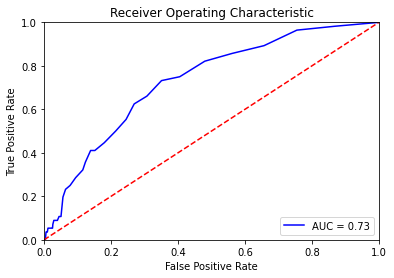

In [99]:
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
cases_true_df = cases_all_df[cases_all_df['Class'] == 1]
cases_false_df = cases_all_df[cases_all_df['Class'] == 0]
cases_true_df.reset_index(drop = True, inplace = True)
cases_false_df.reset_index(drop = True, inplace = True)
cases_resampled_df = pd.DataFrame(x_smote, columns = range(0, 45))
cases_resampled_df['Class'] = y_smote
cases_true_resample_df = cases_resampled_df[cases_resampled_df['Class'] == 1]
cases_false_resampled_df = cases_resampled_df[cases_resampled_df['Class'] == 0]

# Means of Each Distribution(LEFT SIDE: TRUE CASES, RIGHT: FALSE)

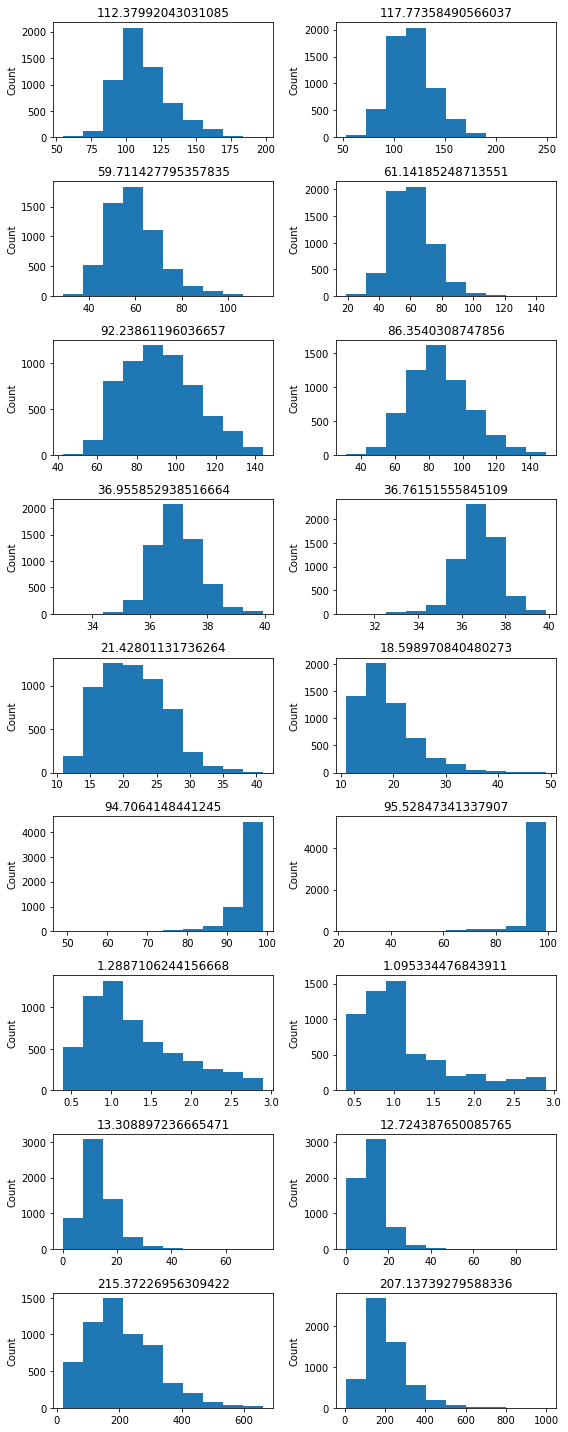

In [34]:
#Histogram for each person and total counted values for each vital over time.

fig, axs = plt.subplots(9,2, figsize = (8,20))
count = 0
i = 0
for x in range(4, 45, 5):
    count = count + 1
    axs[x-(4* count)][0].hist(cases_true_resample_df.iloc[ : , x])
    axs[x-(4* count)][0].set_title(cases_true_resample_df.iloc[ : , x].mean())
    axs[x-(4* count)][0].set_ylabel('Count')
# cases_true_resample_df.iloc[ : , x].mean()
# cases_true_resample_df.iloc[ : , x].var()    
    
    axs[x-(4* count)][1].hist(cases_false_resampled_df.iloc[ : , x])
    axs[x-(4* count)][1].set_title(cases_false_resampled_df.iloc[ : , x].mean())
    axs[x-(4* count)][1].set_ylabel('Count')  
    
    i = i + 1
    
fig.tight_layout()

# Patients who tested positive for ARDS on average had a lower Systolic Blood Pressure, a higher Heart Rate, a Higher Respiration Rate, and a higher Platelets Count